# README:
Upload a damaged painting to get the damage mask of the painting

In [ ]:
!pip install huggingface_hub tensorflow opencv-python matplotlib -q

In [ ]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from huggingface_hub import hf_hub_download
from google.colab import files

In [ ]:
@tf.keras.utils.register_keras_serializable()
def focal_tversky_loss(y_true, y_pred, alpha=0.7, gamma=0.75):
    y_true = tf.cast(y_true > 0.5, tf.float32)

    # Calculate Tversky components
    tp = tf.reduce_sum(y_true * y_pred)
    fn = tf.reduce_sum(y_true * (1 - y_pred))
    fp = tf.reduce_sum((1 - y_true) * y_pred)

    # Tversky index
    tversky = (tp + 1e-6) / (tp + alpha * fn + (1 - alpha) * fp + 1e-6)

    # Focal Tversky Loss
    return tf.pow(1 - tversky, gamma)

try:
    model_path = hf_hub_download(
        repo_id="maximiliannl/artwork-damage-detector",
        filename="model.keras",
        repo_type="model"
    )
    model = tf.keras.models.load_model(
        model_path,
        custom_objects={'focal_tversky_loss': focal_tversky_loss},
        compile=False
    )
    print("Model loaded successfully!")
except Exception as e:
    print(f"Failed to load model: {str(e)}")
    raise


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.keras:   0%|          | 0.00/379M [00:00<?, ?B/s]

Model loaded successfully!


Please upload an image file:


Saving flaked_image.jpg to flaked_image.jpg


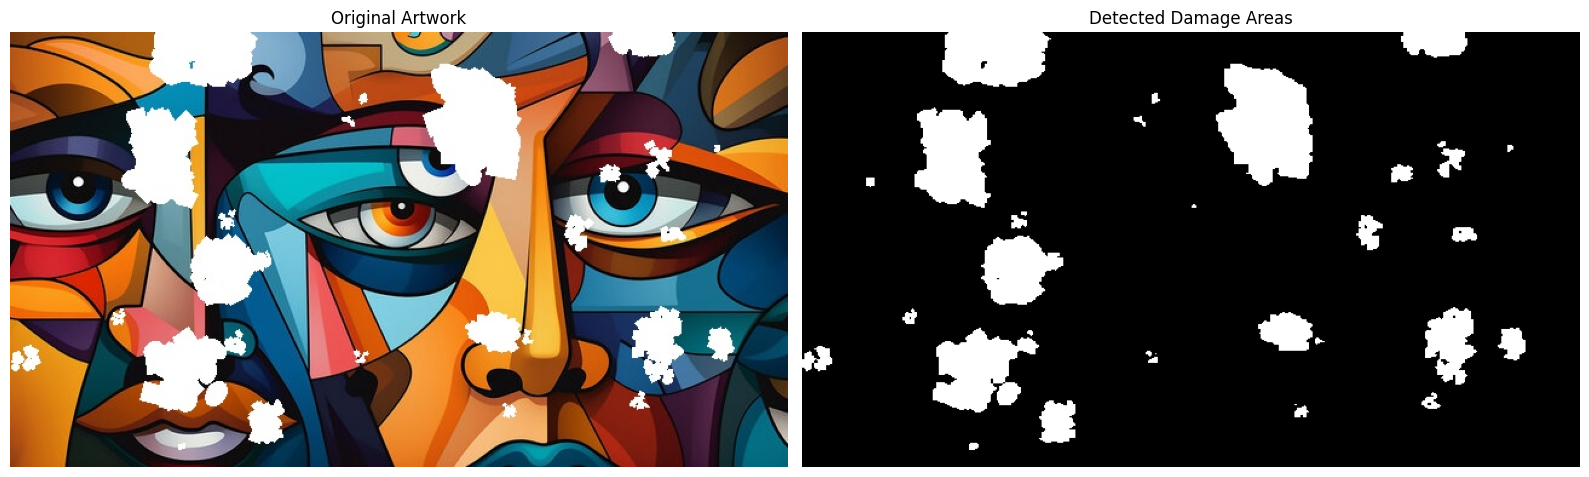

Damage mask saved as 'damage_mask.png'


In [ ]:
def predict_damage(image_path, threshold=0.5):
    try:
        # Read image
        img = cv2.imread(image_path)
        if img is None:
            raise ValueError(f"Could not read image at {image_path}")

        # Convert color and get original size
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        original_size = img.shape[:2]

        # Preprocess (match training)
        processed = cv2.resize(img, (256, 256)).astype(np.float32)/255.0
        pred = model.predict(np.expand_dims(processed, axis=0), verbose=0)[0]

        # Resize prediction to original dimensions
        pred = cv2.resize(pred.squeeze(), (original_size[1], original_size[0]))

        return img, (pred > threshold).astype(np.uint8)

    except Exception as e:
        print(f"Error processing image: {str(e)}")
        return None, None

# Upload and Process Image
def process_uploaded_image():
    # Clear previous uploads
    if os.path.exists("uploaded_image.jpg"):
        os.remove("uploaded_image.jpg")

    # Upload new image
    print("Please upload an image file:")
    uploaded = files.upload()

    if not uploaded:
        print("No file was uploaded")
        return

    # Get the first uploaded file
    image_path = list(uploaded.keys())[0]

    # Verify it's an image
    if not image_path.lower().endswith(('.png', '.jpg', '.jpeg')):
        print("Please upload a valid image file (JPEG/PNG)")
        return

    # Rename for consistency
    os.rename(image_path, "uploaded_image.jpg")

    # Process the image
    original, mask = predict_damage("uploaded_image.jpg")

    if original is not None:
        # Display results
        plt.figure(figsize=(16, 8))

        plt.subplot(1, 2, 1)
        plt.imshow(original)
        plt.title("Original Artwork", fontsize=12)
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(mask, cmap='gray')
        plt.title("Detected Damage Areas", fontsize=12)
        plt.axis('off')

        plt.tight_layout()
        plt.show()

        # Save the mask
        cv2.imwrite("damage_mask.png", mask * 255)
        print("Damage mask saved as 'damage_mask.png'")
    else:
        print("Failed to process the image")

# Run the processing
process_uploaded_image()